In [37]:
import numpy as np
import pandas as pd
import os
from scipy.integrate import quad_vec
CurrentPath = os.getcwd()
sndata = pd.read_csv(CurrentPath + '/2025/parsonage.txt', sep = ' ', engine='python')


1. Setting priors

\# Omega_radiation calculation

$$\epsilon_{rad,0} = \cfrac{4}{c}\sigma T^4 \approx 2.5\times 10^{-15} \mathrm{J/m^3}$$
$$\epsilon_{crit,0} = \cfrac{3c^2H_0^2}{8\pi G} \approx 7.8\times 10^{-10} \mathrm{J/m^3} $$
We can ignore the energy density of radiation since it's small.

The Age of the universe would be come into account for developing prior.

$$t_{Age} >= 15 \text{Gyr}$$

There will be two models to be considered as a candidate for the Universe.

1. Flat LCDM
2. Curved LCDM

In [38]:
# Calculate the Age of the Universe with the given cosmological models
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
# Get the Hubble constant from Planck 2018 cosmology (km/s/Mpc)
H0 = cosmo.H0

# Convert 1/H0 to gigayears
H0_inverse = (1 / H0).to(u.Gyr)

def integrand(z, omegam, omegalamb):
    omega0 = omegam + omegalamb
    y = (1+z)**2*(omegam*(1+z)+omegalamb/((1+z)**2)+(1-omega0))**(1/2)
    return 1/y
def AgeofUniverse(omegam, omegalamb):
    I = quad_vec(integrand,0,np.inf, args=(omegam, omegalamb))
    T = I[0]*H0_inverse # age is in Gyr, 1/H_0 ~ 14.452 Gyr
    return T

In [ ]:
# Calculate the prior for Flat LCDM
omegam = np.linspace(0.0, 10.0, 100000)
omegalamb = 1.0 - omegam
prior = np.zeros(len(omegam))
for i in range(len(omegam)):
    if AgeofUniverse(omegam[i], omegalamb[i]).value >= 15:
        continue
    else:
        prior[i] = 1
        print('omegam:', omegam[i], 'omegalamb:', omegalamb[i], 'Age:', AgeofUniverse(omegam[i], omegalamb[i]).value, 'Gyr')
        break

print(f'Flat LCDM prior: omegam < {omegam[prior==1]}')


omegam: 0.22920229202292025 omegalamb: 0.7707977079770798 Age: 14.99837547945934 Gyr
Flat LCDM prior: omegam < [0.22920229]


/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_1774/3262854091.py:12: RuntimeWarning: invalid value encountered in sqrt
  y = (1+z)**2*(omegam*(1+z)+omegalamb/((1+z)**2)+(1-omega0))**(1/2)


In [126]:
# Calculate the prior for Curved LCDM
omegam = np.linspace(0.0, 5, 500)
omegalamb = np.linspace(0.0, 5, 500)
M, L = np.meshgrid(omegam, omegalamb)
prior = np.zeros(M.shape)
age = AgeofUniverse(M, L)
prior[age.value >= 15] = 1

/var/folders/h8/5hxv73fd07d033x49543ghl00000gn/T/ipykernel_1774/3262854091.py:12: RuntimeWarning: invalid value encountered in sqrt
  y = (1+z)**2*(omegam*(1+z)+omegalamb/((1+z)**2)+(1-omega0))**(1/2)


In [116]:
prior

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])

Text(0.5, 1.0, 'Prior for Curved LCDM')

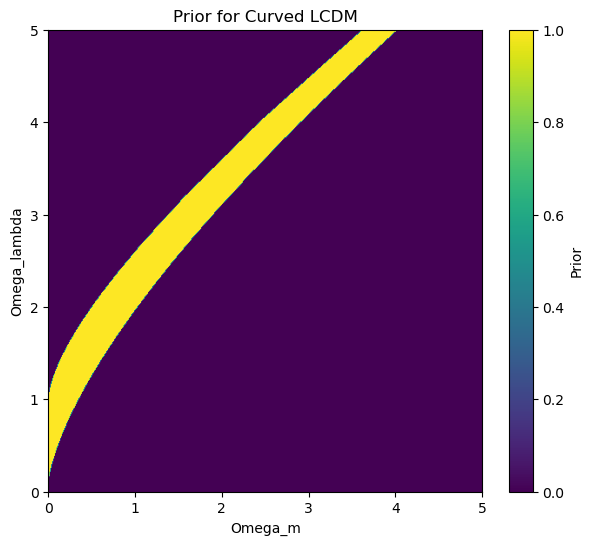

In [127]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.imshow(prior,extent = (0,5,0,5), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Prior')
plt.xlabel('Omega_m')
plt.ylabel('Omega_lambda')
plt.title('Prior for Curved LCDM')

1. Supernovae data:

$$M_B ≈ M_V ≈ −19.30 ± 0.03 + 5 \log(H_0/60) \qquad \text{Hillebrandt, W.; Niemeyer, J. C. (2000)}$$

$$\text{we will calculate} \ \log(d_L) \text{ with distance modulus } m - M = 5\log (d_L/10)$$
-> fit the log(d_L) with cosmological parameters


In [41]:

# observed data
mb = sndata['mb'].values
dmb = sndata['dmb'].values
z = sndata['zcmb'].values
H0 = 67.7 # km/s/Mpc Planck 2018
# distance modulus
absmb = -19.3 + 5*np.log10(H0/60) # H0 = 67.7 km/s/Mpc
dabsmb = 0.03

logdl_obs = (mb - absmb + 5)/5 
dlogdl_obs = (dmb + dabsmb)/5

In [42]:
# calculated data via the model

# model parameters
# 1. Flat Lambda CDM
def integrand_flat_LCDM(z, Omega_m):
    Omega_L = 1 - Omega_m
    H0 = 67.7 # km/s/Mpc
    E = (1+z)**2*np.sqrt(Omega_m*(1+z) + Omega_L/(1+z)**2)
    return 1/E

def Flat_LCDM(z, Omega_m):
    Omega_L = 1 - Omega_m
    H0 = 67.7 # km/s/Mpc
    dp = quad_vec(integrand_flat_LCDM, )

    return dl

# 2. Curvature Lambda CDM


# 3. 